In [1]:
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model, sklearn.calibration
import torch

import loader
from models import MLPClassifier, DummyEstimator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.1  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

max_workers = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

data_dir = "data/acsincome"

In [2]:
## Load ACSIncome dataset from `folktables`
dataset_name = "ACSIncome5"

(inputs_df, labels, label_names, groups, group_names) = loader.cache_dataset(
    f"{data_dir}/acsincome5.pkl", lambda: loader.load_acsincome(
        data_dir,
        n_classes=5,
        sensitive_attr='RAC1P',
    ))
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32, copy=True)
inputs_df.drop(columns=list(inputs_df.filter(regex=f'^RAC1P_')), inplace=True)
inputs_u = inputs_df.values.astype(np.float32)

Group,White alone,Black or African American alone,American Indian or Alaska Native alone,"Asian, Native Hawaiian or Other Pacific Islander alone",Other
Target,,,,,
"[0, 15000.0)",233290,36347,3883,18727,26646
"[15000.0, 30000.0)",232268,35779,3803,16333,27630
"[30000.0, 48600.0)",284095,34890,3652,17202,24060
"[48600.0, 78030.0)",273015,24328,2296,17719,15618
"[78030.0, inf)",275458,16229,1263,29231,10738


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

In [4]:
# Calibrator definition

calibrator_ay_factory = partial(sklearn.calibration.CalibratedClassifierCV,
                             estimator=DummyEstimator(n_classes * n_groups),
                             cv='prefit',
                             method='isotonic')

## Logistic regression

In [5]:
model_name = 'log. reg.'

# Train attribute aware p(Y | X, A) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.13770870779479846


Binned ECE of attribute blind predictor: 0.7865974383592522


In [6]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}


  0%|                                                   | 0/100 [00:00<?, ?it/s]


  1%|▍                                          | 1/100 [00:00<00:28,  3.53it/s]


 32%|█████████████▍                            | 32/100 [00:05<00:12,  5.59it/s]


 64%|██████████████████████████▉               | 64/100 [00:09<00:05,  6.71it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 96%|████████████████████████████████████████▎ | 96/100 [00:55<00:02,  1.37it/s]


100%|█████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


  0%|                                                   | 0/100 [00:00<?, ?it/s]


 32%|█████████████▍                            | 32/100 [00:09<00:20,  3.39it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 96%|████████████████████████████████████████▎ | 96/100 [02:40<00:07,  1.82s/it]


100%|█████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


  0%|                                                    | 0/80 [00:00<?, ?it/s]


 40%|█████████████████▏                         | 32/80 [00:02<00:03, 14.21it/s]


 80%|██████████████████████████████████▍        | 64/80 [00:04<00:01, 15.57it/s]


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 19.17it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/80 [00:00<?, ?it/s]


 40%|█████████████████▏                         | 32/80 [00:00<00:01, 46.93it/s]


 80%|██████████████████████████████████▍        | 64/80 [00:00<00:00, 82.47it/s]


100%|███████████████████████████████████████████| 80/80 [00:00<00:00, 92.42it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


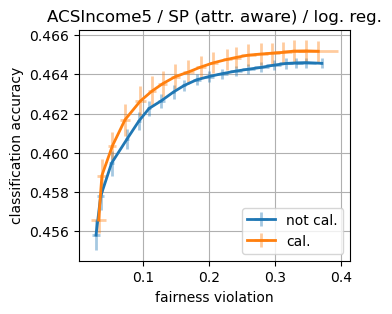

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.464564  0.000259  0.370922  0.002360
0.360  0.464601  0.000252  0.347344  0.015449
0.340  0.464586  0.000268  0.331923  0.011291
0.320  0.464556  0.000262  0.317056  0.010033
0.300  0.464471  0.000246  0.298330  0.011073
0.280  0.464358  0.000259  0.279509  0.011647
0.260  0.464265  0.000247  0.259865  0.010229
0.240  0.464171  0.000275  0.241060  0.009283
0.220  0.464039  0.000260  0.220230  0.008332
0.200  0.463892  0.000261  0.200110  0.006842
0.180  0.463724  0.000283  0.181154  0.006130
0.160  0.463437  0.000278  0.162371  0.003035
0.140  0.463104  0.000373  0.146052  0.002949
0.120  0.462655  0.000356  0.127510  0.005569
0.100  0.462261  0.000381  0.108851  0.003276
0.080  0.461625  0.000441  0.093493  0.003472
0.060  0.460705  0.000517  0.075456  0.003368
0.040  0.459476  0.000636  0.051955  0.003782
0.020  0.457784  0.000715  0.035337  0.005442
0.001  0.455807  0.000773  0.028281  0.006382

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.465181  0.000539  0.365707  0.030312
0.360  0.465198  0.000545  0.346980  0.020512
0.340  0.465188  0.000550  0.328617  0.017381
0.320  0.465122  0.000525  0.312753  0.013371
0.300  0.465083  0.000534  0.296174  0.011823
0.280  0.465038  0.000545  0.278603  0.010901
0.260  0.464981  0.000554  0.259621  0.011035
0.240  0.464861  0.000555  0.240579  0.007701
0.220  0.464765  0.000554  0.227532  0.006598
0.200  0.464593  0.000531  0.206721  0.006615
0.180  0.464374  0.000572  0.187348  0.007591
0.160  0.464120  0.000614  0.168576  0.008203
0.140  0.463887  0.000637  0.148862  0.006625
0.120  0.463527  0.000663  0.129611  0.006774
0.100  0.463144  0.000769  0.113114  0.005755
0.080  0.462639  0.000785  0.095561  0.008147
0.060  0.461693  0.000817  0.072454  0.008206
0.040  0.460358  0.000712  0.053235  0.006031
0.020  0.458844  0.000832  0.037238  0.007937
0.001  0.456569  0.000653  0.032325  0.010902

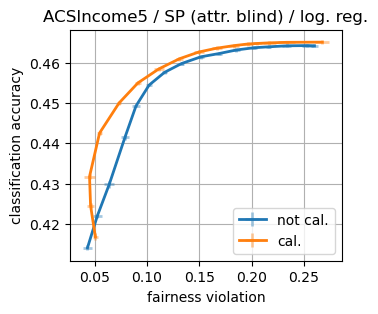

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.464201  0.000327  0.259847  0.003291
0.260  0.464253  0.000322  0.253173  0.005078
0.240  0.464196  0.000343  0.233510  0.004234
0.220  0.463947  0.000336  0.216197  0.002461
0.200  0.463714  0.000352  0.202007  0.002786
0.180  0.463164  0.000414  0.185435  0.003036
0.160  0.462282  0.000431  0.168889  0.003191
0.140  0.461466  0.000476  0.151483  0.003124
0.120  0.459801  0.000474  0.133027  0.002550
0.100  0.457614  0.000317  0.116785  0.002606
0.080  0.454449  0.000219  0.102006  0.003070
0.060  0.449263  0.000368  0.089486  0.003759
0.040  0.441524  0.000627  0.079003  0.003533
0.020  0.429791  0.000757  0.063905  0.004614
0.010  0.421961  0.000607  0.052542  0.004565
0.001  0.414095  0.000623  0.043181  0.004668

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.465108  0.000474  0.267361  0.006629
0.260  0.465061  0.000408  0.233453  0.007937
0.240  0.464930  0.000454  0.216667  0.006337
0.220  0.464782  0.000461  0.205508  0.003962
0.200  0.464645  0.000385  0.196370  0.004699
0.180  0.464245  0.000476  0.183036  0.005286
0.160  0.463600  0.000535  0.166484  0.004722
0.140  0.462655  0.000484  0.149483  0.004807
0.120  0.460990  0.000471  0.131032  0.003785
0.100  0.458468  0.000452  0.111337  0.004694
0.080  0.454981  0.000386  0.091301  0.002537
0.060  0.449987  0.000555  0.073279  0.001656
0.040  0.442551  0.000458  0.054695  0.002067
0.020  0.431754  0.000525  0.045124  0.004842
0.010  0.424563  0.000615  0.046111  0.003223
0.001  0.416852  0.000802  0.050648  0.002357

In [7]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2,
                0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.001]
alphas_blind = [np.inf, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1,
                0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)


  0%|                                                    | 0/75 [00:00<?, ?it/s]


 43%|██████████████████▎                        | 32/75 [00:01<00:01, 29.90it/s]


 85%|████████████████████████████████████▋      | 64/75 [00:01<00:00, 56.47it/s]


100%|███████████████████████████████████████████| 75/75 [00:01<00:00, 58.31it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/75 [00:00<?, ?it/s]


 43%|█████████████████▉                        | 32/75 [00:00<00:00, 103.26it/s]


 85%|████████████████████████████████████▋      | 64/75 [00:01<00:00, 31.23it/s]


100%|███████████████████████████████████████████| 75/75 [00:01<00:00, 40.82it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:01<00:02, 25.09it/s]


 75%|████████████████████████████████▍          | 64/85 [00:01<00:00, 51.48it/s]


100%|███████████████████████████████████████████| 85/85 [00:01<00:00, 58.98it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:04<00:06,  7.65it/s]


 75%|████████████████████████████████▍          | 64/85 [00:14<00:05,  4.00it/s]


100%|███████████████████████████████████████████| 85/85 [00:14<00:00,  5.72it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


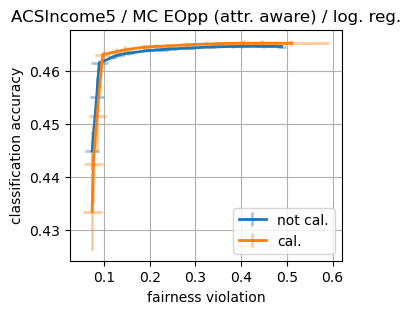

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.464564  0.000259   0.488157  0.009126
0.450  0.464593  0.000254   0.450973  0.021557
0.400  0.464595  0.000259   0.401816  0.015487
0.350  0.464569  0.000260   0.381580  0.011052
0.300  0.464483  0.000271   0.334663  0.009405
0.250  0.464273  0.000272   0.286500  0.012983
0.200  0.464099  0.000286   0.242669  0.017875
0.180  0.463983  0.000286   0.224458  0.015259
0.150  0.463818  0.000295   0.198749  0.013341
0.100  0.463315  0.000317   0.152959  0.012929
0.080  0.462989  0.000314   0.131997  0.013697
0.050  0.462559  0.000351   0.118534  0.008922
0.020  0.461416  0.000661   0.089337  0.018729
0.010  0.455033  0.003714   0.083811  0.015146
0.001  0.444899  0.003696   0.074121  0.015283

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.465181  0.000539   0.509806  0.082705
0.450  0.465197  0.000552   0.445301  0.049396
0.400  0.465185  0.000548   0.403315  0.036364
0.350  0.465117  0.000519   0.348844  0.015071
0.300  0.465029  0.000547   0.322634  0.017681
0.250  0.464884  0.000463   0.279809  0.018595
0.200  0.464660  0.000480   0.236786  0.013874
0.180  0.464582  0.000503   0.212947  0.014271
0.150  0.464423  0.000570   0.186910  0.013297
0.100  0.463949  0.000653   0.145759  0.011310
0.080  0.463595  0.000609   0.126019  0.014081
0.050  0.463033  0.000711   0.097027  0.016016
0.020  0.451531  0.006812   0.084690  0.018533
0.010  0.442412  0.007365   0.076575  0.020631
0.001  0.433419  0.007293   0.073933  0.020802

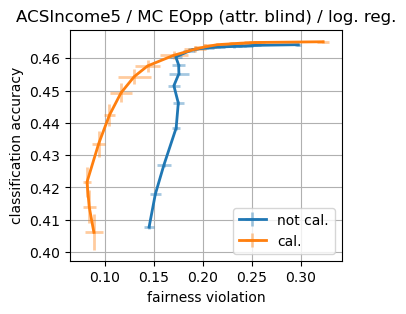

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.464201  0.000327   0.297145  0.003039
0.300  0.463998  0.000357   0.254118  0.005454
0.280  0.463806  0.000345   0.243345  0.007651
0.260  0.463656  0.000380   0.232026  0.007649
0.240  0.463494  0.000374   0.216378  0.006423
0.220  0.463228  0.000395   0.204372  0.007035
0.200  0.462722  0.000364   0.189824  0.005400
0.180  0.462204  0.000394   0.185705  0.006355
0.150  0.460431  0.000375   0.172328  0.005995
0.120  0.457929  0.000307   0.175248  0.006835
0.100  0.455239  0.000324   0.175541  0.010441
0.080  0.451493  0.000404   0.170392  0.006048
0.060  0.446148  0.000494   0.174906  0.005535
0.040  0.438398  0.000511   0.172715  0.003773
0.020  0.426873  0.000400   0.160159  0.007102
0.010  0.417942  0.000187   0.151524  0.005742
0.001  0.407742  0.000490   0.145154  0.005212

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.465108  0.000474   0.322304  0.006372
0.300  0.464882  0.000511   0.252601  0.011118
0.280  0.464790  0.000480   0.247615  0.011459
0.260  0.464666  0.000508   0.238559  0.011494
0.240  0.464480  0.000530   0.229476  0.011377
0.220  0.464202  0.000585   0.214554  0.014801
0.200  0.463534  0.000750   0.202370  0.011593
0.180  0.462819  0.000858   0.192136  0.011261
0.150  0.460900  0.001245   0.170145  0.014330
0.120  0.457628  0.001885   0.143630  0.012815
0.100  0.454287  0.002299   0.129895  0.016840
0.080  0.449274  0.002941   0.116501  0.010785
0.060  0.442366  0.003433   0.104689  0.005535
0.040  0.433514  0.004019   0.093723  0.006666
0.020  0.421657  0.004624   0.081865  0.004055
0.010  0.414071  0.005232   0.084106  0.006701
0.001  0.406094  0.005533   0.088872  0.008975

In [8]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'MC EOpp'
alphas_aware = [np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08,
                0.05, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1,
                0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)


  0%|                                                    | 0/75 [00:00<?, ?it/s]


 43%|██████████████████▎                        | 32/75 [00:02<00:04, 10.70it/s]


 85%|████████████████████████████████████▋      | 64/75 [00:04<00:00, 14.71it/s]


100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.31it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/75 [00:00<?, ?it/s]


 43%|██████████████████▎                        | 32/75 [00:02<00:03, 10.86it/s]


 85%|████████████████████████████████████▋      | 64/75 [00:03<00:00, 24.30it/s]


100%|███████████████████████████████████████████| 75/75 [00:03<00:00, 24.01it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:01<00:02, 20.22it/s]


 41%|█████████████████▋                         | 35/85 [00:02<00:03, 14.49it/s]


 75%|████████████████████████████████▍          | 64/85 [00:02<00:00, 33.64it/s]


100%|███████████████████████████████████████████| 85/85 [00:02<00:00, 35.50it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:06<00:10,  4.99it/s]


 75%|████████████████████████████████▍          | 64/85 [00:10<00:03,  6.06it/s]


100%|███████████████████████████████████████████| 85/85 [00:10<00:00,  7.79it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


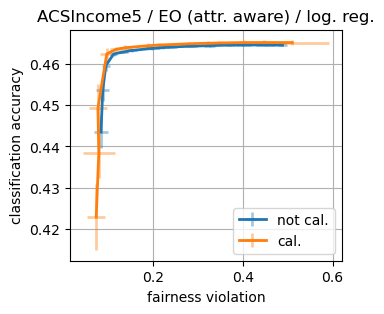

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.464564  0.000259  0.488157  0.009126
0.450  0.464593  0.000254  0.450973  0.021557
0.400  0.464600  0.000259  0.400836  0.016209
0.350  0.464577  0.000267  0.372013  0.011087
0.300  0.464442  0.000260  0.325820  0.012268
0.250  0.464301  0.000247  0.286376  0.011970
0.200  0.464121  0.000266  0.240388  0.011715
0.180  0.463990  0.000288  0.222324  0.015145
0.150  0.463769  0.000313  0.197722  0.016621
0.100  0.463281  0.000319  0.152133  0.012107
0.080  0.462882  0.000318  0.131643  0.011905
0.050  0.462409  0.000367  0.111088  0.007179
0.020  0.459595  0.001308  0.093627  0.009634
0.010  0.453633  0.002657  0.086749  0.014153
0.001  0.443532  0.003814  0.082812  0.016068

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.465181  0.000539  0.509806  0.082705
0.450  0.465196  0.000552  0.445824  0.050441
0.400  0.465185  0.000548  0.403315  0.036364
0.350  0.465089  0.000554  0.346976  0.017218
0.300  0.465027  0.000543  0.321818  0.017888
0.250  0.464884  0.000459  0.278637  0.018832
0.200  0.464672  0.000510  0.234052  0.011304
0.180  0.464596  0.000558  0.212868  0.012139
0.150  0.464406  0.000655  0.186824  0.011489
0.100  0.463939  0.000598  0.137345  0.014400
0.080  0.463555  0.000625  0.116573  0.014562
0.050  0.462428  0.001480  0.095676  0.014769
0.020  0.449340  0.005702  0.075998  0.020122
0.010  0.438364  0.006033  0.077873  0.036109
0.001  0.422901  0.008047  0.072151  0.020580

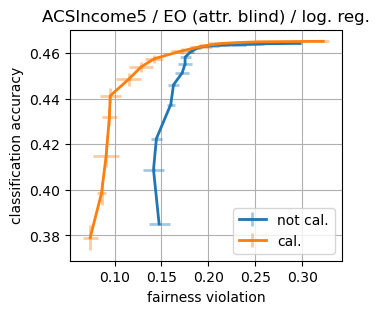

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.464201  0.000327  0.297145  0.003039
0.300  0.463998  0.000357  0.254118  0.005454
0.280  0.463806  0.000345  0.243345  0.007651
0.260  0.463656  0.000380  0.232026  0.007649
0.240  0.463494  0.000374  0.216378  0.006423
0.220  0.463228  0.000395  0.204372  0.007035
0.200  0.462722  0.000364  0.190999  0.002959
0.180  0.462204  0.000394  0.188361  0.003251
0.150  0.460483  0.000387  0.180960  0.004008
0.120  0.458146  0.000306  0.175173  0.005955
0.100  0.455223  0.000325  0.175069  0.007903
0.080  0.451270  0.000362  0.172041  0.007491
0.060  0.446023  0.000511  0.162788  0.005598
0.040  0.437396  0.000515  0.159857  0.004011
0.020  0.422434  0.000751  0.144570  0.005865
0.010  0.408824  0.000609  0.141481  0.011398
0.001  0.385047  0.000359  0.147431  0.011129

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.465108  0.000474  0.322304  0.006372
0.300  0.464882  0.000511  0.252601  0.011118
0.280  0.464790  0.000480  0.247615  0.011459
0.260  0.464666  0.000508  0.238559  0.011494
0.240  0.464480  0.000530  0.229476  0.011377
0.220  0.464202  0.000585  0.214554  0.014801
0.200  0.463534  0.000750  0.202370  0.011593
0.180  0.462819  0.000858  0.192136  0.011261
0.150  0.460951  0.001284  0.172205  0.012150
0.120  0.457510  0.001807  0.142410  0.009696
0.100  0.453842  0.002185  0.128206  0.012388
0.080  0.448428  0.002806  0.114877  0.013352
0.060  0.441208  0.003317  0.095376  0.010980
0.040  0.431938  0.003869  0.094473  0.007702
0.020  0.414738  0.004831  0.090977  0.014020
0.010  0.398482  0.005233  0.086085  0.004910
0.001  0.379030  0.005533  0.074025  0.008080

In [9]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08,
                0.05, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1,
                0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

## Gradient boosting decision tree

In [10]:
model_name = 'GBDT'

# Train attribute aware p(Y | X, A) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain, verbosity=0)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain,
                                         verbosity=0)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.09461207017470216


Binned ECE of attribute blind predictor: 1.5996342089948496


In [11]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}


  0%|                                                    | 0/90 [00:00<?, ?it/s]


 36%|███████████████▎                           | 32/90 [00:06<00:11,  4.90it/s]


 71%|██████████████████████████████▌            | 64/90 [00:08<00:03,  8.54it/s]


100%|███████████████████████████████████████████| 90/90 [00:08<00:00, 10.80it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/90 [00:00<?, ?it/s]


 36%|███████████████▎                           | 32/90 [00:03<00:07,  8.28it/s]


 71%|██████████████████████████████▌            | 64/90 [00:05<00:02, 12.27it/s]


100%|███████████████████████████████████████████| 90/90 [00:05<00:00, 16.08it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/70 [00:00<?, ?it/s]


 46%|███████████████████▋                       | 32/70 [00:03<00:03, 10.58it/s]


 91%|███████████████████████████████████████▎   | 64/70 [00:04<00:00, 14.79it/s]


100%|███████████████████████████████████████████| 70/70 [00:04<00:00, 15.26it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/70 [00:00<?, ?it/s]


 46%|███████████████████▋                       | 32/70 [00:00<00:01, 37.35it/s]


 91%|███████████████████████████████████████▎   | 64/70 [00:02<00:00, 28.36it/s]


100%|███████████████████████████████████████████| 70/70 [00:02<00:00, 32.15it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


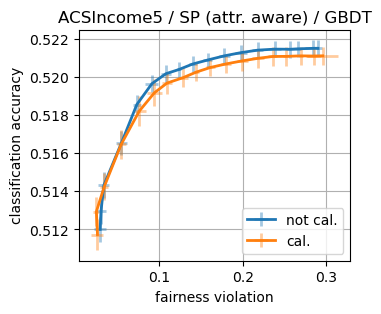

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.521496  0.000423  0.289463  0.001685
0.300  0.521494  0.000413  0.284239  0.010013
0.280  0.521468  0.000419  0.265989  0.003462
0.260  0.521446  0.000434  0.256926  0.005197
0.240  0.521452  0.000438  0.238393  0.007031
0.220  0.521399  0.000406  0.217824  0.006950
0.200  0.521271  0.000421  0.198187  0.006886
0.180  0.521100  0.000420  0.178000  0.006698
0.160  0.520883  0.000391  0.158122  0.005458
0.140  0.520670  0.000397  0.140056  0.004873
0.120  0.520385  0.000408  0.123828  0.002155
0.100  0.520163  0.000441  0.108140  0.005557
0.080  0.519639  0.000434  0.091377  0.007748
0.060  0.518546  0.000518  0.073364  0.005109
0.040  0.516538  0.000633  0.055038  0.007016
0.020  0.514313  0.000676  0.033945  0.006401
0.010  0.512967  0.000701  0.030595  0.005706
0.001  0.512003  0.000657  0.029513  0.006745

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.521102  0.000470  0.295539  0.018416
0.300  0.521091  0.000477  0.284663  0.008740
0.280  0.521099  0.000489  0.269657  0.002373
0.260  0.521073  0.000499  0.251962  0.003837
0.240  0.521067  0.000494  0.235921  0.005528
0.220  0.520970  0.000485  0.218097  0.006924
0.200  0.520836  0.000518  0.199356  0.006359
0.180  0.520678  0.000473  0.180076  0.006467
0.160  0.520490  0.000464  0.161361  0.005550
0.140  0.520248  0.000455  0.144394  0.002953
0.120  0.519957  0.000500  0.128755  0.006341
0.100  0.519672  0.000563  0.109473  0.006023
0.080  0.519159  0.000701  0.094276  0.008805
0.060  0.518199  0.000785  0.076233  0.007922
0.040  0.516454  0.000775  0.054622  0.005490
0.020  0.514245  0.000723  0.034448  0.004799
0.010  0.512937  0.000746  0.025035  0.003720
0.001  0.511734  0.000824  0.026353  0.007170

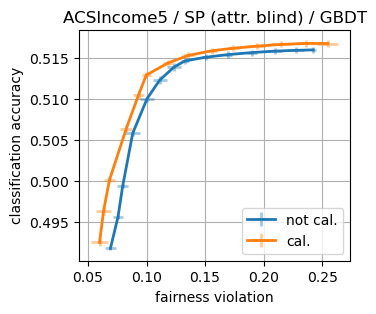

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.516011  0.000385  0.242268  0.002085
0.220  0.515950  0.000368  0.227269  0.007048
0.200  0.515859  0.000366  0.209625  0.005759
0.180  0.515682  0.000367  0.189982  0.004245
0.160  0.515437  0.000391  0.169847  0.003123
0.140  0.515109  0.000386  0.150422  0.003003
0.120  0.514657  0.000400  0.132660  0.003411
0.100  0.513917  0.000464  0.123578  0.006022
0.080  0.512335  0.000459  0.111296  0.006161
0.060  0.510037  0.000385  0.100388  0.005692
0.040  0.505813  0.000353  0.088153  0.006605
0.020  0.499312  0.000250  0.079540  0.004911
0.010  0.495618  0.000252  0.075632  0.004074
0.001  0.491756  0.000242  0.069151  0.004418

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.516787  0.000404  0.254682  0.008932
0.220  0.516796  0.000392  0.236467  0.008612
0.200  0.516677  0.000368  0.214720  0.008499
0.180  0.516470  0.000355  0.194287  0.006914
0.160  0.516214  0.000371  0.174204  0.004979
0.140  0.515895  0.000397  0.155593  0.004804
0.120  0.515334  0.000407  0.135632  0.004689
0.100  0.514409  0.000420  0.118324  0.003865
0.080  0.512925  0.000412  0.099722  0.003824
0.060  0.510510  0.000474  0.093169  0.005049
0.040  0.506373  0.000394  0.082637  0.005204
0.020  0.500074  0.000367  0.068253  0.004725
0.010  0.496334  0.000506  0.063272  0.006367
0.001  0.492467  0.000410  0.059819  0.006880

In [12]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14,
                0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06,
                0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)


  0%|                                                    | 0/80 [00:00<?, ?it/s]


 40%|█████████████████▏                         | 32/80 [00:01<00:02, 20.52it/s]


 80%|██████████████████████████████████▍        | 64/80 [00:01<00:00, 42.88it/s]


100%|███████████████████████████████████████████| 80/80 [00:01<00:00, 46.00it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/80 [00:00<?, ?it/s]


 40%|█████████████████▏                         | 32/80 [00:01<00:01, 29.07it/s]


 80%|██████████████████████████████████▍        | 64/80 [00:01<00:00, 52.10it/s]


100%|███████████████████████████████████████████| 80/80 [00:01<00:00, 58.12it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:01<00:02, 18.25it/s]


 75%|████████████████████████████████▍          | 64/85 [00:01<00:00, 37.37it/s]


100%|███████████████████████████████████████████| 85/85 [00:01<00:00, 42.80it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:03<00:05,  9.03it/s]


 75%|████████████████████████████████▍          | 64/85 [00:03<00:01, 20.55it/s]


100%|███████████████████████████████████████████| 85/85 [00:03<00:00, 22.90it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


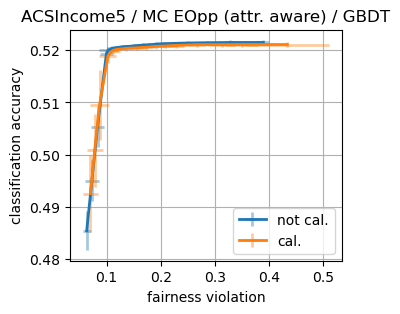

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.521496  0.000423   0.389024  0.010882
0.350  0.521491  0.000433   0.327109  0.007184
0.300  0.521449  0.000409   0.284653  0.015362
0.250  0.521392  0.000405   0.249256  0.005505
0.200  0.521266  0.000410   0.205163  0.010250
0.180  0.521195  0.000401   0.191786  0.016956
0.160  0.521098  0.000382   0.185923  0.019603
0.140  0.521008  0.000406   0.167178  0.020247
0.120  0.520836  0.000418   0.151956  0.021459
0.100  0.520662  0.000396   0.128417  0.014391
0.080  0.520377  0.000431   0.110245  0.008637
0.060  0.520010  0.000386   0.102661  0.016070
0.040  0.519236  0.000528   0.099515  0.012023
0.020  0.505384  0.003867   0.083257  0.012612
0.010  0.494979  0.003953   0.072835  0.013426
0.001  0.485438  0.003754   0.063305  0.007567

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.521102  0.000470   0.433341  0.077320
0.350  0.521097  0.000481   0.349021  0.030911
0.300  0.521082  0.000486   0.311991  0.024759
0.250  0.521074  0.000511   0.266523  0.016731
0.200  0.520910  0.000485   0.227329  0.015734
0.180  0.520818  0.000458   0.207645  0.015918
0.160  0.520739  0.000485   0.190729  0.018452
0.140  0.520598  0.000462   0.173597  0.014497
0.120  0.520473  0.000472   0.156255  0.012841
0.100  0.520365  0.000453   0.136484  0.013112
0.080  0.520175  0.000477   0.119029  0.007610
0.060  0.519927  0.000612   0.111093  0.013962
0.040  0.518893  0.001358   0.102390  0.015547
0.020  0.509498  0.006667   0.086963  0.018201
0.010  0.500827  0.007010   0.078023  0.014644
0.001  0.492540  0.007425   0.070224  0.013809

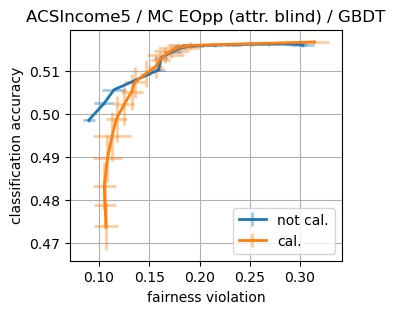

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.516011  0.000385   0.302569  0.011415
0.280  0.516363  0.000399   0.296082  0.010698
0.260  0.516389  0.000381   0.288366  0.011472
0.240  0.516324  0.000405   0.269187  0.008992
0.220  0.516289  0.000384   0.252570  0.008948
0.200  0.516178  0.000369   0.233991  0.008649
0.180  0.516071  0.000351   0.215277  0.007192
0.160  0.515951  0.000381   0.194877  0.009970
0.140  0.515836  0.000398   0.183777  0.009903
0.120  0.515737  0.000439   0.185809  0.009893
0.100  0.515261  0.000412   0.179854  0.007161
0.080  0.514552  0.000375   0.173179  0.009564
0.060  0.513112  0.000281   0.161868  0.006773
0.040  0.510252  0.000224   0.159153  0.006432
0.020  0.505649  0.000181   0.114917  0.012110
0.010  0.502455  0.000283   0.104925  0.010010
0.001  0.498531  0.000322   0.089714  0.006097

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.516787  0.000404   0.314237  0.014746
0.280  0.515982  0.000803   0.190182  0.022704
0.260  0.515448  0.001143   0.178842  0.020672
0.240  0.514704  0.001603   0.172037  0.017861
0.220  0.513770  0.001924   0.165859  0.018211
0.200  0.512517  0.002265   0.160322  0.010025
0.180  0.511017  0.002729   0.156251  0.007844
0.160  0.509337  0.003165   0.146325  0.005456
0.140  0.507368  0.003603   0.135450  0.010574
0.120  0.505198  0.004187   0.132409  0.010876
0.100  0.502273  0.004783   0.125178  0.009927
0.080  0.498902  0.005352   0.117366  0.010650
0.060  0.494778  0.005672   0.112859  0.018960
0.040  0.489600  0.005576   0.108360  0.014340
0.020  0.483150  0.005589   0.105144  0.011274
0.010  0.478664  0.005603   0.105983  0.010747
0.001  0.473751  0.005550   0.106991  0.012307

In [13]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'MC EOpp'
alphas_aware = [np.inf, 0.35, 0.3, 0.25, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
                0.06, 0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12,
                0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)


  0%|                                                    | 0/80 [00:00<?, ?it/s]


 40%|█████████████████▏                         | 32/80 [00:01<00:01, 26.42it/s]


 80%|██████████████████████████████████▍        | 64/80 [00:01<00:00, 49.93it/s]


100%|███████████████████████████████████████████| 80/80 [00:01<00:00, 55.00it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/80 [00:00<?, ?it/s]


 40%|█████████████████▏                         | 32/80 [00:04<00:06,  7.03it/s]


 80%|██████████████████████████████████▍        | 64/80 [00:04<00:00, 16.09it/s]


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.85it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:06<00:10,  4.93it/s]


 75%|████████████████████████████████▍          | 64/85 [00:06<00:01, 11.27it/s]


100%|███████████████████████████████████████████| 85/85 [00:06<00:00, 12.54it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:03<00:05,  9.87it/s]


 75%|████████████████████████████████▍          | 64/85 [00:03<00:00, 22.16it/s]


100%|███████████████████████████████████████████| 85/85 [00:03<00:00, 24.78it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


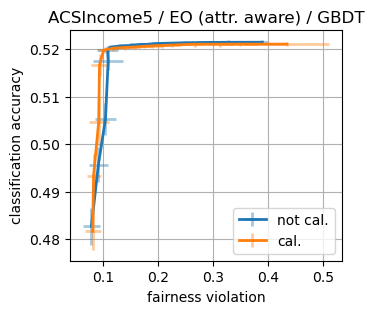

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.521496  0.000423  0.389024  0.010882
0.350  0.521491  0.000433  0.327109  0.007184
0.300  0.521449  0.000409  0.284653  0.015362
0.250  0.521392  0.000405  0.249256  0.005505
0.200  0.521251  0.000386  0.205209  0.010288
0.180  0.521184  0.000400  0.191273  0.015619
0.160  0.521063  0.000392  0.182548  0.013443
0.140  0.521030  0.000403  0.167661  0.019985
0.120  0.520825  0.000431  0.152883  0.023039
0.100  0.520680  0.000380  0.128214  0.012941
0.080  0.520433  0.000441  0.113272  0.008841
0.060  0.519963  0.000421  0.107964  0.019409
0.040  0.517598  0.001963  0.109182  0.027776
0.020  0.505317  0.003464  0.104247  0.019113
0.010  0.495706  0.003692  0.091410  0.017283
0.001  0.482696  0.003843  0.078703  0.015968

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.521102  0.000470  0.433341  0.077320
0.350  0.521097  0.000481  0.349021  0.030911
0.300  0.521082  0.000486  0.311991  0.024759
0.250  0.521074  0.000511  0.266523  0.016731
0.200  0.520918  0.000472  0.225522  0.013795
0.180  0.520813  0.000447  0.206568  0.014911
0.160  0.520738  0.000419  0.188540  0.015998
0.140  0.520636  0.000415  0.173846  0.014518
0.120  0.520492  0.000471  0.157707  0.011701
0.100  0.520397  0.000488  0.138877  0.010957
0.080  0.520250  0.000499  0.118457  0.008007
0.060  0.519827  0.000604  0.100964  0.010230
0.040  0.516745  0.002302  0.093480  0.015618
0.020  0.504615  0.005030  0.091895  0.018409
0.010  0.493339  0.004577  0.082642  0.012744
0.001  0.481642  0.003980  0.080955  0.014768

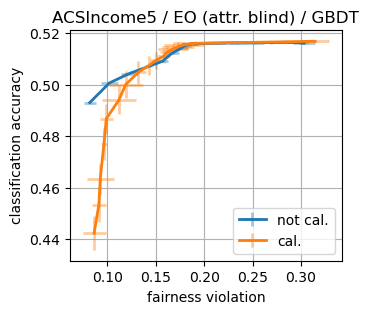

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.516011  0.000385  0.302569  0.011415
0.280  0.516363  0.000399  0.296082  0.010698
0.260  0.516389  0.000381  0.288366  0.011472
0.240  0.516324  0.000405  0.269187  0.008992
0.220  0.516289  0.000384  0.252570  0.008948
0.200  0.516177  0.000367  0.233991  0.008649
0.180  0.516083  0.000353  0.215277  0.007192
0.160  0.515950  0.000397  0.196240  0.009785
0.140  0.515770  0.000435  0.185774  0.009019
0.120  0.515594  0.000429  0.184350  0.008817
0.100  0.515016  0.000482  0.179483  0.006858
0.080  0.514055  0.000403  0.175982  0.007199
0.060  0.512184  0.000324  0.166856  0.007226
0.040  0.508960  0.000262  0.156554  0.006321
0.020  0.504260  0.000035  0.122625  0.008795
0.010  0.500604  0.000151  0.102109  0.008901
0.001  0.492979  0.000148  0.081812  0.006182

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.516787  0.000404  0.314237  0.014746
0.280  0.515982  0.000803  0.190182  0.022704
0.260  0.515448  0.001143  0.179177  0.020253
0.240  0.514704  0.001603  0.173019  0.016584
0.220  0.513770  0.001924  0.167859  0.015585
0.200  0.512517  0.002265  0.161651  0.007240
0.180  0.511018  0.002730  0.158263  0.006717
0.160  0.509333  0.003191  0.149903  0.005417
0.140  0.507363  0.003625  0.142743  0.003780
0.120  0.504719  0.004547  0.131928  0.008378
0.100  0.500009  0.005312  0.118931  0.017682
0.080  0.493973  0.005588  0.111874  0.017643
0.060  0.486724  0.005773  0.098932  0.006625
0.040  0.476991  0.006076  0.096473  0.003114
0.020  0.463496  0.005836  0.092742  0.013659
0.010  0.453351  0.006531  0.091247  0.007223
0.001  0.442385  0.006656  0.086367  0.011889

In [14]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.35, 0.3, 0.25, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08,
                0.06, 0.04, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12,
                0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

## ReLU network

In [15]:
model_name = 'MLP'

# Train attribute aware p(Y | X, A) predictor
predictor_y = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                            activation=torch.nn.ReLU(),
                            n_classes=n_classes,
                            n_epochs=20,
                            batch_size=128,
                            lr=1e-3,
                            gamma=0.8,
                            device=device,
                            random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute blind p(A, Y | X) predictor
predictor_u_ay = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                               activation=torch.nn.ReLU(),
                               n_classes=n_groups * n_classes,
                               n_epochs=20,
                               batch_size=128,
                               lr=1e-3,
                               gamma=0.8,
                               device=device,
                               random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print('Binned ECE of attribute aware predictor:',
      utils.calibration_error(predictor_y.predict_proba(inputs_), labels_))
print(
    'Binned ECE of attribute blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_))

Binned ECE of attribute aware predictor: 0.08288856415786952


Binned ECE of attribute blind predictor: 0.7589545690642889


In [16]:
# Precompute P(A, Y | X, A) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'p_ay_x': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'p_ay_x': probas_ay_u_}


  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:14<00:24,  2.15it/s]


 75%|████████████████████████████████▍          | 64/85 [00:18<00:05,  3.75it/s]


100%|███████████████████████████████████████████| 85/85 [00:18<00:00,  4.48it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/85 [00:00<?, ?it/s]


 38%|████████████████▏                          | 32/85 [00:00<00:00, 57.06it/s]


 75%|████████████████████████████████▍          | 64/85 [00:00<00:00, 82.57it/s]


100%|██████████████████████████████████████████| 85/85 [00:00<00:00, 102.28it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/80 [00:00<?, ?it/s]


 40%|█████████████████▏                         | 32/80 [00:03<00:05,  8.30it/s]


 80%|██████████████████████████████████▍        | 64/80 [00:04<00:01, 14.35it/s]


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.16it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/80 [00:00<?, ?it/s]


 40%|█████████████████▏                         | 32/80 [00:02<00:03, 13.60it/s]


 80%|██████████████████████████████████▍        | 64/80 [00:04<00:00, 16.23it/s]


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 19.70it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


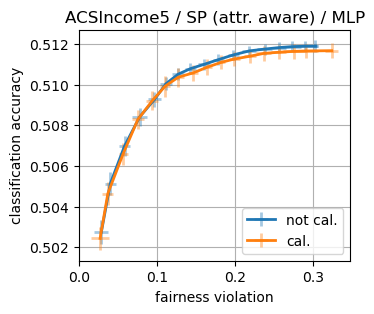

Results for attribute aware (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.511887  0.000290  0.302706  0.003409
0.300  0.511882  0.000268  0.289581  0.015800
0.280  0.511863  0.000278  0.272261  0.011959
0.260  0.511816  0.000253  0.255931  0.008874
0.240  0.511743  0.000270  0.237604  0.009900
0.220  0.511653  0.000258  0.217816  0.009076
0.200  0.511458  0.000260  0.197511  0.007285
0.180  0.511225  0.000266  0.178242  0.007357
0.160  0.510985  0.000269  0.159326  0.007580
0.140  0.510780  0.000264  0.142363  0.007363
0.120  0.510506  0.000305  0.126481  0.007125
0.100  0.510037  0.000309  0.110940  0.007184
0.080  0.509267  0.000385  0.096270  0.008311
0.060  0.508409  0.000435  0.077220  0.009866
0.040  0.506975  0.000505  0.057845  0.007387
0.020  0.505124  0.000569  0.039575  0.007114
0.001  0.502755  0.000586  0.028163  0.008868

Results for attribute aware (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.511664  0.000371  0.323439  0.008227
0.300  0.511649  0.000366  0.290196  0.015926
0.280  0.511629  0.000354  0.274517  0.013578
0.260  0.511587  0.000345  0.255746  0.009735
0.240  0.511529  0.000358  0.236219  0.009171
0.220  0.511392  0.000343  0.218604  0.007997
0.200  0.511253  0.000328  0.198433  0.006843
0.180  0.511088  0.000341  0.181691  0.004546
0.160  0.510851  0.000382  0.163805  0.005658
0.140  0.510571  0.000411  0.145830  0.006647
0.120  0.510362  0.000466  0.126927  0.006626
0.100  0.509919  0.000511  0.109860  0.006026
0.080  0.509194  0.000467  0.093239  0.007354
0.060  0.508282  0.000463  0.074959  0.008167
0.040  0.506593  0.000532  0.056035  0.005762
0.020  0.504641  0.000556  0.036467  0.007187
0.001  0.502437  0.000581  0.026540  0.011063

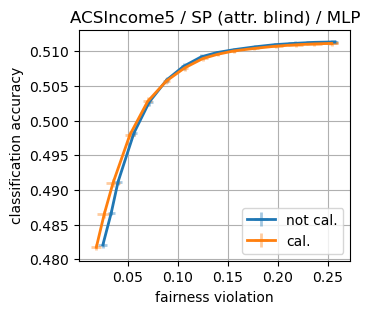

Results for attribute blind (not calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.511344  0.000246  0.256603  0.002466
0.260  0.511338  0.000252  0.253640  0.006306
0.240  0.511286  0.000253  0.236613  0.008240
0.220  0.511143  0.000279  0.217376  0.007468
0.200  0.510954  0.000276  0.197018  0.005803
0.180  0.510640  0.000300  0.177089  0.004939
0.160  0.510228  0.000308  0.156096  0.003988
0.140  0.509812  0.000294  0.139215  0.001699
0.120  0.509209  0.000349  0.123607  0.000991
0.100  0.507825  0.000461  0.105745  0.002188
0.080  0.505870  0.000456  0.089000  0.001781
0.060  0.502689  0.000510  0.071583  0.003355
0.040  0.498222  0.000408  0.056277  0.002549
0.020  0.491152  0.000380  0.040339  0.003609
0.010  0.486706  0.000342  0.033609  0.003702
0.001  0.482094  0.000391  0.025258  0.004408

Results for attribute blind (calibrated):


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.511125  0.000304  0.253706  0.006314
0.260  0.511128  0.000287  0.251740  0.007909
0.240  0.511060  0.000278  0.235989  0.007869
0.220  0.510935  0.000253  0.217893  0.007429
0.200  0.510732  0.000271  0.197712  0.006978
0.180  0.510413  0.000260  0.176574  0.004995
0.160  0.510050  0.000255  0.156067  0.002474
0.140  0.509566  0.000260  0.139904  0.001712
0.120  0.508959  0.000328  0.125173  0.004953
0.100  0.507611  0.000423  0.106958  0.002928
0.080  0.505694  0.000424  0.088447  0.003324
0.060  0.502766  0.000613  0.069948  0.004202
0.040  0.497954  0.000550  0.052218  0.005341
0.020  0.490967  0.000551  0.035260  0.006968
0.010  0.486496  0.000484  0.026551  0.007290
0.001  0.481739  0.000424  0.018712  0.004838

In [17]:
## Post-processing for statistical parity
criterion = 'sp'
criterion_name = 'SP'
alphas_aware = [np.inf, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14,
                0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.001]
alphas_blind = [np.inf, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1,
                0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)


  0%|                                                    | 0/75 [00:00<?, ?it/s]


 43%|██████████████████▎                        | 32/75 [00:02<00:02, 15.07it/s]


 85%|████████████████████████████████████▋      | 64/75 [00:02<00:00, 33.00it/s]


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 32.79it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/75 [00:00<?, ?it/s]


 43%|██████████████████▎                        | 32/75 [00:02<00:02, 15.18it/s]


 85%|████████████████████████████████████▋      | 64/75 [00:02<00:00, 33.22it/s]


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 33.01it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/90 [00:00<?, ?it/s]


 36%|███████████████▎                           | 32/90 [00:01<00:02, 21.21it/s]


 71%|██████████████████████████████▌            | 64/90 [00:02<00:01, 24.46it/s]


100%|███████████████████████████████████████████| 90/90 [00:02<00:00, 33.55it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



  0%|                                                    | 0/90 [00:00<?, ?it/s]


 36%|███████████████▎                           | 32/90 [00:01<00:02, 26.93it/s]


 71%|██████████████████████████████▌            | 64/90 [00:01<00:00, 52.17it/s]


100%|███████████████████████████████████████████| 90/90 [00:01<00:00, 64.24it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


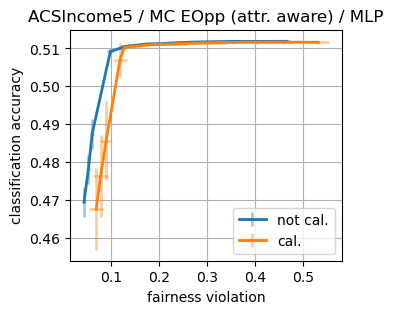

Results for attribute aware (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.511887  0.000290   0.465690  0.007384
0.450  0.511881  0.000281   0.437054  0.021332
0.400  0.511863  0.000281   0.386236  0.017706
0.350  0.511862  0.000281   0.352481  0.011780
0.300  0.511783  0.000274   0.306858  0.018991
0.250  0.511673  0.000268   0.268623  0.014865
0.200  0.511427  0.000245   0.220784  0.012409
0.180  0.511274  0.000267   0.202022  0.009937
0.150  0.511214  0.000258   0.176755  0.011193
0.100  0.510559  0.000278   0.128815  0.009178
0.080  0.510111  0.000228   0.119842  0.004449
0.050  0.509210  0.000656   0.098161  0.007310
0.020  0.487497  0.003930   0.060441  0.004349
0.010  0.478034  0.003890   0.052347  0.004080
0.001  0.469407  0.003924   0.043366  0.002924

Results for attribute aware (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.511664  0.000371   0.530735  0.022930
0.450  0.511663  0.000374   0.456478  0.022738
0.400  0.511655  0.000370   0.403211  0.030411
0.350  0.511628  0.000363   0.356267  0.017474
0.300  0.511559  0.000347   0.320735  0.020290
0.250  0.511437  0.000349   0.283708  0.020525
0.200  0.511229  0.000352   0.234201  0.025321
0.180  0.511159  0.000370   0.212786  0.020964
0.150  0.511076  0.000391   0.188689  0.018192
0.100  0.510577  0.000456   0.148256  0.013394
0.080  0.510285  0.000476   0.126991  0.012699
0.050  0.506936  0.004597   0.118262  0.013667
0.020  0.485625  0.010471   0.089513  0.012410
0.010  0.476274  0.010769   0.077823  0.014960
0.001  0.467568  0.010873   0.068754  0.014874

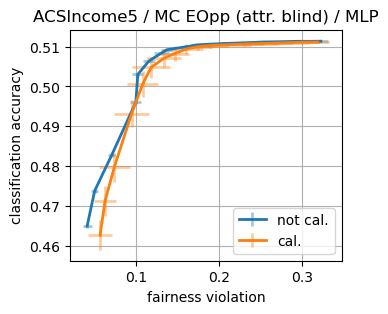

Results for attribute blind (not calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.511344  0.000246   0.322737  0.008611
0.320  0.511310  0.000254   0.310044  0.008453
0.300  0.511321  0.000235   0.297356  0.008130
0.280  0.511229  0.000254   0.277254  0.009035
0.260  0.511145  0.000263   0.253099  0.008092
0.240  0.510969  0.000267   0.233666  0.007692
0.220  0.510792  0.000261   0.209718  0.008306
0.200  0.510624  0.000255   0.191885  0.005895
0.180  0.510418  0.000264   0.172592  0.004913
0.150  0.510067  0.000271   0.163833  0.006414
0.120  0.509202  0.000328   0.136867  0.006788
0.100  0.508393  0.000284   0.130306  0.008695
0.080  0.506367  0.000253   0.115092  0.007319
0.060  0.503026  0.000330   0.101651  0.006763
0.040  0.496049  0.000392   0.099259  0.006620
0.020  0.482695  0.000492   0.069932  0.004611
0.010  0.473813  0.000546   0.049501  0.004415
0.001  0.464976  0.000613   0.040404  0.005500

Results for attribute blind (calibrated):


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.511125  0.000304   0.319318  0.013715
0.320  0.511099  0.000325   0.301868  0.019686
0.300  0.510997  0.000327   0.286199  0.022977
0.280  0.510874  0.000333   0.267500  0.021975
0.260  0.510766  0.000352   0.250625  0.022188
0.240  0.510616  0.000370   0.229637  0.024072
0.220  0.510457  0.000440   0.210357  0.027592
0.200  0.510265  0.000509   0.189513  0.021382
0.180  0.509969  0.000736   0.174311  0.017523
0.150  0.509383  0.001210   0.160235  0.019968
0.120  0.508244  0.001864   0.146170  0.017350
0.100  0.507086  0.002236   0.133303  0.019981
0.080  0.504761  0.002639   0.117745  0.022604
0.060  0.500627  0.003164   0.107575  0.019075
0.040  0.493147  0.003409   0.094109  0.021561
0.020  0.479732  0.003674   0.073204  0.018716
0.010  0.471225  0.003675   0.061992  0.013394
0.001  0.462673  0.003780   0.056084  0.014949

In [18]:
## Post-processing for equal opportunity
criterion = 'eopp'
criterion_name = 'MC EOpp'
alphas_aware = [np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08,
                0.05, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15,
                0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)

  0%|                                                    | 0/75 [00:00<?, ?it/s]

 21%|█████████▏                                 | 16/75 [00:00<00:03, 17.06it/s]

 43%|██████████████████▎                        | 32/75 [00:03<00:05,  7.45it/s]

 43%|██████████████████▎                        | 32/75 [00:19<00:05,  7.45it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 64%|███████████████████████████▌               | 48/75 [01:10<00:53,  1.97s/it]

 85%|████████████████████████████████████▋      | 64/75 [02:16<00:31,  2.83s/it]

100%|███████████████████████████████████████████| 75/75 [02:16<00:00,  1.82s/it]

  0%|                                                    | 0/75 [00:00<?, ?it/s]

 21%|█████████▏                                 | 16/75 [00:00<00:01, 36.78it/s]

 43%|██████████████████▎                        | 32/75 [00:00<00:00, 51.95it/s]

 43%|██████████████████▎                        | 32/75 [00:12<00:00, 51.95it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 64%|███████████████████████████▌               | 48/75 [01:09<00:53,  1.99s/it]

 85%|████████████████████████████████████▋      | 64/75 [02:38<00:37,  3.38s/it]

100%|███████████████████████████████████████████| 75/75 [02:38<00:00,  2.11s/it]

  0%|                                                    | 0/90 [00:00<?, ?it/s]

 18%|███████▋                                   | 16/90 [00:00<00:04, 16.69it/s]

 18%|███████▋                                   | 16/90 [00:16<00:04, 16.69it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 53%|██████████████████████▉                    | 48/90 [03:34<03:28,  4.96s/it]

 71%|██████████████████████████████▌            | 64/90 [06:13<02:53,  6.69s/it]

 89%|██████████████████████████████████████▏    | 80/90 [08:03<01:07,  6.73s/it]

100%|███████████████████████████████████████████| 90/90 [08:03<00:00,  5.37s/it]

  0%|                                                    | 0/90 [00:00<?, ?it/s]

 18%|███████▋                                   | 16/90 [00:00<00:03, 24.25it/s]

 36%|███████████████▎                           | 32/90 [00:01<00:01, 30.15it/s]

 36%|███████████████▎                           | 32/90 [00:17<00:01, 30.15it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 53%|██████████████████████▉                    | 48/90 [04:04<04:52,  6.97s/it]

 71%|██████████████████████████████▌            | 64/90 [09:06<05:03, 11.66s/it]

 89%|██████████████████████████████████████▏    | 80/90 [10:52<01:38,  9.85s/it]

100%|███████████████████████████████████████████| 90/90 [10:52<00:00,  7.25s/it]

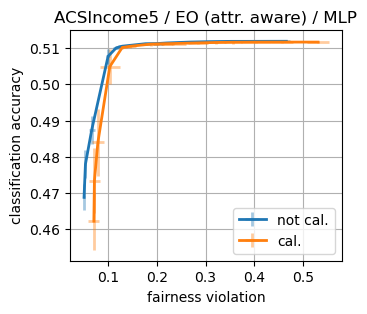

Results for attribute aware (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.511887  0.000290  0.465690  0.007384
0.450  0.511881  0.000281  0.437054  0.021332
0.400  0.511863  0.000281  0.386236  0.017706
0.350  0.511862  0.000281  0.352481  0.011780
0.300  0.511783  0.000274  0.306858  0.018991
0.250  0.511673  0.000268  0.268623  0.014865
0.200  0.511427  0.000245  0.220784  0.012409
0.180  0.511273  0.000273  0.202067  0.009922
0.150  0.511215  0.000246  0.176834  0.010569
0.100  0.510533  0.000259  0.129054  0.008925
0.080  0.510087  0.000256  0.116681  0.006019
0.050  0.507735  0.002054  0.099949  0.004320
0.020  0.487504  0.003854  0.066447  0.006431
0.010  0.478009  0.003854  0.053478  0.001878
0.001  0.468853  0.003577  0.050609  0.002955

Results for attribute aware (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.511664  0.000371  0.530735  0.022930
0.450  0.511663  0.000374  0.456478  0.022738
0.400  0.511655  0.000370  0.403211  0.030411
0.350  0.511628  0.000363  0.356267  0.017474
0.300  0.511559  0.000347  0.320735  0.020290
0.250  0.511437  0.000349  0.283708  0.020525
0.200  0.511266  0.000345  0.234115  0.025012
0.180  0.511211  0.000345  0.212584  0.020934
0.150  0.511100  0.000427  0.187122  0.016624
0.100  0.510512  0.000404  0.145332  0.011279
0.080  0.510173  0.000471  0.128963  0.012424
0.050  0.504886  0.004865  0.103405  0.020908
0.020  0.483966  0.009296  0.078957  0.012191
0.010  0.473437  0.008946  0.071907  0.010696
0.001  0.462281  0.008028  0.070752  0.011519

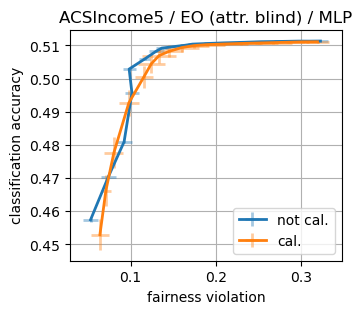

Results for attribute blind (not calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.511344  0.000246  0.322737  0.008611
0.320  0.511310  0.000254  0.310044  0.008453
0.300  0.511321  0.000235  0.297356  0.008130
0.280  0.511229  0.000254  0.277254  0.009035
0.260  0.511145  0.000263  0.253099  0.008092
0.240  0.510969  0.000267  0.233666  0.007692
0.220  0.510792  0.000261  0.209718  0.008306
0.200  0.510624  0.000255  0.191885  0.005895
0.180  0.510418  0.000264  0.172592  0.004913
0.150  0.510068  0.000271  0.163824  0.006407
0.120  0.509214  0.000312  0.136617  0.006807
0.100  0.508289  0.000270  0.130162  0.008673
0.080  0.505959  0.000336  0.116708  0.006415
0.060  0.502891  0.000419  0.098341  0.007748
0.040  0.495716  0.000476  0.101606  0.008083
0.020  0.480948  0.000248  0.092405  0.008964
0.010  0.470436  0.000474  0.073992  0.008368
0.001  0.457431  0.000639  0.053057  0.009313

Results for attribute blind (calibrated):


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.511125  0.000304  0.319318  0.013715
0.320  0.511099  0.000325  0.301868  0.019686
0.300  0.510997  0.000327  0.286199  0.022977
0.280  0.510874  0.000333  0.267500  0.021975
0.260  0.510766  0.000352  0.250625  0.022188
0.240  0.510616  0.000370  0.229637  0.024072
0.220  0.510457  0.000440  0.210357  0.027592
0.200  0.510265  0.000509  0.189513  0.021382
0.180  0.509969  0.000736  0.174311  0.017523
0.150  0.509384  0.001211  0.160295  0.019831
0.120  0.508224  0.001797  0.145172  0.016911
0.100  0.506969  0.002304  0.133494  0.020363
0.080  0.504503  0.002823  0.124351  0.015907
0.060  0.500503  0.003419  0.115560  0.010298
0.040  0.492719  0.003893  0.098001  0.011525
0.020  0.477600  0.004661  0.080372  0.011022
0.010  0.466257  0.004772  0.071044  0.006011
0.001  0.452966  0.004700  0.064056  0.010725

In [19]:
## Post-processing for equalized odds
criterion = 'eo'
criterion_name = 'EO'
alphas_aware = [np.inf, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08,
                0.05, 0.02, 0.01, 0.001]
alphas_blind = [np.inf, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.15,
                0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001]

df_aware = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    alphas_aware,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_kwargs,
)

df_blind = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    alphas_blind,
    seeds,
    criterion,
    ['accuracy', f'delta_{criterion}'],
    calibrator_ay_factory=calibrator_ay_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_aware_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. aware) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute aware (not calibrated):")
display(df_aware)
print("Results for attribute aware (calibrated):")
display(df_aware_cal)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, f'delta_{criterion}', 'accuracy', label='not cal.')
utils.plot_results(ax, df_blind_cal, f'delta_{criterion}', 'accuracy', label='cal.')
ax.set_xlabel(f"fairness violation")
ax.set_ylabel("classification accuracy")
ax.set_title(f"{dataset_name} / {criterion_name} (attr. blind) / {model_name}")
ax.legend()
plt.show()

print("Results for attribute blind (not calibrated):")
display(df_blind)
print("Results for attribute blind (calibrated):")
display(df_blind_cal)